In [8]:
#This notebook will try to detect the gender information from ML model. Sklearn.
import pandas as pd
import text_cleaner

In [9]:
# Read the training dataset, and set usecols=[] the columns we want to build the paragraph, objective "gender"
df = pd.read_csv("~/Downloads/products_20230224.csv", usecols=["title", "body_html", "gender"])

In [10]:
# cols = ["gender","raw_text","title"]
# df = pd.read_csv("~/Downloads/products_20230224", usecols=cols)

# This loop will build a new column named 'raw_text', which is the result of concating title + (processed) body text.
for row in range(df.shape[0]):
    df.loc[row, 'raw_text'] = text_cleaner.raw_content(df.loc[row, 'title'], None, df.loc[row, 'body_html'], None)



In [14]:
#check randomly one of the processed samples.
df.loc[2988, 'raw_text']

'Unicorn Booty (Gift) card. Shopping for someone else but not sure what to give them? Give the gift of choice with a gift card. Gift cards are delivered by email and contain checkout redemption instructions. Our gift cards have no additional processing fees.'

In [16]:
df.columns

Index(['gender', 'raw_text'], dtype='object')

In [17]:
# We only needs two columns one is the original "description text" and the target "gender"
df = df[['gender','raw_text']].copy()


In [19]:
df.loc[1]['raw_text']

'THUNDER Miles Silvas Omni Team Hollow 147 Skateboard Trucks. THUNDER Miles Silvas Omni Team Hollow 147 Skateboard Trucks Fits Deck Sizes 7.9 - 8.12'

In [20]:
#(Not necessary)sometimes, the gender could contain unicode not corret label, but this code block doesn't have to run.
count = 0
type = set()
for row in range(df.shape[0]):
    gender_words = df.loc[row]['gender']
    if gender_words == 'women\xa0':
        df.loc[row, 'gender'] = gender_words.replace(u'\xa0', u'')
        count+=1
    if gender_words == 'men\xa0':
        df.loc[row, 'gender'] = gender_words.replace(u'\xa0', u'')
        count += 1
print(count)
df.shape

0


(31894, 2)

In [21]:
# remove the rows with either one of the columns are empty. notnull()
df = df[pd.notnull(df['raw_text'])]
df = df[pd.notnull(df['gender'])]
df.shape

(31691, 2)

In [22]:
col = ["gender", "raw_text"]
#modify names of columns
#df.columns = ["Gender", "Product_Description"]
# Analyse the data entries briefly.
df.rename(columns={'gender': 'Gender', 'raw_text': 'Product_Description'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31691 entries, 0 to 31893
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               31691 non-null  object
 1   Product_Description  31691 non-null  object
dtypes: object(2)
memory usage: 742.8+ KB


In [17]:
#(Not necessary) drop the unknown/unset/broken
index_broken = df[((df.Gender == "broken") | (df.Gender == "unknown") | (df.Gender == "unset") |(df.Gender == "unisex/unknown"))].index
df = df.drop(index_broken)
df.shape

(26485, 2)

In [23]:
#create the dictionary and new column to store "gender:0~5" key-value.
df['gender_id'] = df['Gender'].factorize()[0]
category_id_df = df[['Gender', 'gender_id']].drop_duplicates().sort_values('gender_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['gender_id', 'Gender']].values)
df.head()

,Gender,Product_Description,gender_id
0,women,Pear Drop. The Candy Shop auntsanduncles Candy...,0
1,na,THUNDER Miles Silvas Omni Team Hollow 147 Skat...,1
2,men,Stance Ground Control.,2
3,men,Stance JMB Untitled 1982. We have partnered wi...,2
4,women,Mrs. Raisin Cookie. Medium Handbag 25.00 x 25....,0


In [24]:
# Check our target dictionary.
category_to_id

{'women': 0, 'na': 1, 'men': 2, 'unisex': 3, 'boys': 4, 'girls': 5}

In [25]:
id_to_category

{0: 'women', 1: 'na', 2: 'men', 3: 'unisex', 4: 'boys', 5: 'girls'}

In [27]:
#df = df.query('(Gender == "women")').sample(n=2000)

In [24]:
#(Not neccessary to run) Modify the bias
temp_df = df.query('(Gender == "men")').sample(n=4000)
index_men = df[(df.Gender == "men")].index
df = df.drop(index_men)

#df = df.append(temp_df)
df = pd.concat([df, temp_df])
temp_df = df.query('(Gender == "women")').sample(n=4000)
index_women = df[(df.Gender == "women")].index

df = df.drop(index_women)
#df = df.append(temp_df)
df = pd.concat([df, temp_df])


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31691 entries, 0 to 31893
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               31691 non-null  object
 1   Product_Description  31691 non-null  object
 2   gender_id            31691 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 990.3+ KB


In [27]:
df = df.sort_index()

In [28]:
df.head()

,Gender,Product_Description,gender_id
0,women,Pear Drop. The Candy Shop auntsanduncles Candy...,0
1,na,THUNDER Miles Silvas Omni Team Hollow 147 Skat...,1
2,men,Stance Ground Control.,2
3,men,Stance JMB Untitled 1982. We have partnered wi...,2
4,women,Mrs. Raisin Cookie. Medium Handbag 25.00 x 25....,0


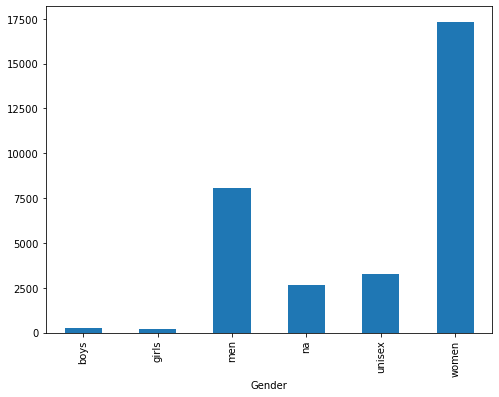

In [29]:
# Visualize our data distribution
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Gender').Product_Description.count().plot.bar(ylim=0)
plt.show()

#### need to take the number of 'men' and 'women' to around 3000, otherwise it will cause the bias of the data.

In [30]:
df.columns

Index(['Gender', 'Product_Description', 'gender_id'], dtype='object')

In [31]:
# Create our tf-idf vectorizer, which is used for transfer our words to the vector by frequency of the word.
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Product_Description).toarray()
labels = df.gender_id
features.shape

(31691, 84101)

In [32]:
# Chi-square algo to analyse correlation. 
from sklearn.feature_selection import chi2
import numpy as np
N = 2 # Freedom degree
for Gender, gender_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == gender_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Gender))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'boys':
  . Most correlated unigrams:
       . boy
       . boys
  . Most correlated bigrams:
       . vans boys
       . shirt boys
# 'girls':
  . Most correlated unigrams:
       . ahi
       . girls
  . Most correlated bigrams:
       . lining critically
       . grow tech
# 'men':
  . Most correlated unigrams:
       . shirt
       . men
  . Most correlated bigrams:
       . shirt white
       . shirt black
# 'na':
  . Most correlated unigrams:
       . candle
       . skateboard
  . Most correlated bigrams:
       . sheet black
       . skateboard deck
# 'unisex':
  . Most correlated unigrams:
       . vinyl
       . sticker
  . Most correlated bigrams:
       . kids size
       . 10 12
# 'women':
  . Most correlated unigrams:
       . women
       . dress
  . Most correlated bigrams:
       . fit guide
       . sky fit


In [33]:
#Separate the test and train data set
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Product_Description'], df['Gender'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [34]:
print(clf.predict(count_vect.transform(["This blue v neck jacket is sweet and beautiful and cute"])))

['women']


In [35]:
print(clf.predict(count_vect.transform(["This is male jacket and so cool."])))

['women']


In [36]:
print(clf.predict(count_vect.transform(["Baby strawberry girls' t-shirt is so perfect for age under 12."])))

['women']


In [44]:
print(clf.predict(count_vect.transform(["male's hoodie"])))

['men']


In [45]:
# Test couple more models and see their performance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC # seems the highest classification model always. You can try the rest
# or just chooose LinearSVC to save training time, LinearSVC takes 2.30 mins in Mac M1 to train 30K data. 
from sklearn.model_selection import cross_val_score

models = [
    #RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC() #, 
    #MultinomialNB(),
    #LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [46]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC    0.911426
Name: accuracy, dtype: float64

In [47]:
# Make sure the index is continuous
df = df.reset_index()

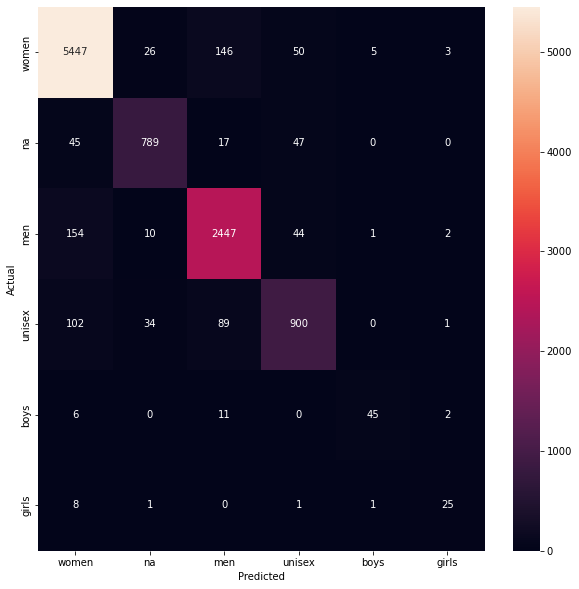

In [48]:
# See the confuse matrix. 
import seaborn as sns
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Gender.values, yticklabels=category_id_df.Gender.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [42]:
#(Not necessary to run) This code block is to show how the wrong examples happens for help us to tune training data or modify our tools.
from IPython.display import display
for predicted in category_id_df.gender_id:
  for actual in category_id_df.gender_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Gender', 'Product_Description']])
      print('')

'na' predicted as 'women' : 10 examples.


,Gender,Product_Description
1543,na,URBAN CALM | MILD SOAP FOR SENSITIVE SKIN & FA...
10723,na,"Bamboo Brush. 5L Bamboo Brush, Natural"
380,na,Textured Throw / Natural. This signature throw...
644,na,Aromatherapy Eye Pillow / Marbled Sienna. Made...
379,na,Textured Throw / Black. This signature throw i...
8325,na,BURTON EST Hardware Set. BURTON EST Hardware Set
768,na,Paint Dipped Pouch in Fig Navy and Grey. This ...
1999,na,Luxury Sheet Set. Our Luxury Sheets are made o...
8206,na,BATALEON Stuntwood Bindings Youth Black 2022. ...
6694,na,BURTON Reflex Combo Binding Disc Black. BURTON...



'unisex' predicted as 'women' : 30 examples.


,Gender,Product_Description
5923,unisex,Matt & Nat Nia Vegan Wristlet Wallet Vintage. ...
121,unisex,Waxed Canvas Tote / Brown. This 10oz waxed cot...
1892,unisex,LOVE YOU MOST Shareable Compliment Cards.
7470,unisex,ELEMENT Timber Garden Snake Skateboard Grip. I...
11278,unisex,OKGN Mesh Back Hat. Description: Perfect for t...
10815,unisex,Apple Watch Strap Small (38 40mm) Black. Desig...
11289,unisex,The Dane Ballcap. Description: Sharp black-on-...
2118,unisex,Okanagan Love Stickers. Designed locally right...
11163,unisex,Gridlock. The Gridlok features two interlockin...
11284,unisex,Four Season iPhone Case. Description: Think Gl...



'men' predicted as 'women' : 39 examples.


,Gender,Product_Description
5482,men,Bellroy Tokyo Tote Second Edition. A clever ki...
5138,men,TOM FORD CLARK SHINY ROSE GOLD BLACK POLAR GRA...
11867,men,Shorts Drawstring Elastic Beach Shorts. Drawst...
10956,men,"Miami Chain. Single 45cm, 55cm, 65cm or 75cm l..."
10881,men,Wilder Face Mask. Stay safe with the Wilder Fa...
146,men,California Pullover / Diesel Gray. Lightweight...
12776,men,TOMS WOOLEN BERKLY SLIPPERS. Additional Inform...
10886,men,Gene Pool Crew. crew neck
1870,men,Oneill Premium L/S Rash Guard. Premium Skins 5...
1201,men,FEDORA DENIM BLUE. The elegant Wide Brim Denim...



'women' predicted as 'na' : 17 examples.


,Gender,Product_Description
2177,women,Twisted Tomboy Roll On Perfume. These perfumes...
4832,women,Speckled Pottery Mug.
722,women,Scarf / Bridget Peach. Inspired by the captiva...
713,women,Refining Cleanser / Micro Exfoliating Botanica...
11575,women,Stainless Steel Twist Version of The LAST Neck...
11584,women,Mask Necklace 4 Ways To Wear Stainless Steel. ...
6750,women,DAKINE Jo Jo Crossbody Bag Petal Maze. DAKINE ...
2214,women,Epic Blend Face Mask Oatmeal. Sensitive or irr...
2193,women,I Love My Muff Green Feminine Care Kit. Green ...
12483,women,TOFINO TOWEL THE HARMONY BATH ROBE TOASTED ALM...



'unisex' predicted as 'na' : 26 examples.


,Gender,Product_Description
12450,unisex,APT.6 GRAPEFRUIT & NEROLI HAND & BODY. Additio...
12353,unisex,SUN BUM MINERAL SPF 30 FACE TINT. Additional I...
11099,unisex,"Round Box Chain. Single 55cm, 65cm or 75cm len..."
12449,unisex,APT.6 POMEGRANATE HAND & BODY. Additional Info...
12751,unisex,SUN BUM SELF TANNING TOWELLETE 5 PACK. Additio...
12427,unisex,PINK MARTINI THE LOMMA BOWL CAST ALUMINUM GOLD...
12425,unisex,PINK MARTINI HAND BRAIDED COTTON CUSHION. Hand...
12428,unisex,PINK MARTINI HAND WOVEN COTTON CUSHION. Beauti...
12383,unisex,TOFINO TOWEL THE SUN FLARE TOWEL TEAL. Our cus...
2686,unisex,Herschel Fifteen Hip Pack Light Grey Crosshatc...



'women' predicted as 'unisex' : 37 examples.


,Gender,Product_Description
11932,women,Onesie Sugar Sugar Onesie. Sugar sugar onesie
11633,women,Top CDN Heritage Tee. CDN heritage tee Product...
10631,women,Y2K Denim Short.
5739,women,COAL The Mel Beanie. The Mel is our top sellin...
4840,women,Stripe Top.
335,women,Go Pouch Set / Painted Daisies. Our Go Pouch S...
3735,women,Cozy Scarf Butter. Fabric - 100% Viscose
1573,women,Body Glide For Her Travel Size 22g. CFH8 Trave...
1915,women,Bryan Anthony s Still Falling For You Necklace...
4477,women,No Lurking Eyewear Tort. With smaller proporti...



'na' predicted as 'unisex' : 31 examples.


,Gender,Product_Description
12311,na,POWERDOT 2.0 SMART MUSCLE STIMULATOR RED. This...
12891,na,Coolibar Virasana Performance Sun Bandana UPF ...
10255,na,SUN BUM Baby Bum SPF 30 Lotion 3oz.. A baby is...
791,na,Alice Tie Mask / Black Multi Olive Multi. The ...
823,na,Sun Bum Original SPF 50 lotion.
11198,na,"Soul Mates 18"". MEANING The bird is a symbol o..."
2206,na,Sun Bum Spf 15 Tanning Oil. SPF 15 Tanning Oil...
7062,na,VOLCOM Skate Vitals Milton Martinez Duffle Bag...
1817,na,Light in the Dark Cards. Cards of Support to G...
8031,na,VOLCOM Thomas Hooper Fa Waist Pack Multi. Wais...



'men' predicted as 'unisex' : 33 examples.


,Gender,Product_Description
5625,men,Matt & Nat Tom Vegan Briefcase Dwell. Briefcas...
4606,men,O’Neill traveler cossa staple.
5530,men,BURTON DAY HIKER 28L OLIVE DRAB COTTON BACKPACK.
5583,men,Oakley Jupiter Squared (Polarized). Details Ju...
7438,men,HERSCHEL Scout Rubber Patch Cap Peacoat Wrinkl...
5472,men,"SPY Czar (Polarized). The King of Kings, the C..."
11420,men,Smoky Quartz Talisman Necklace. This is one of...
5573,men,Aunts & Uncles Edward. When you just have too ...
5931,men,Matt & Nat Soren Vegan Briefcase Vintage. Brie...
5981,men,Oakley Holbrook XL. Details The look of Holbro...



'women' predicted as 'men' : 71 examples.


,Gender,Product_Description
4774,women,Banana Republic Sunlight Cardigan.
3002,women,Nike Women s Air Max 90 Black/White. CQ2560-00...
11015,women,Kiss Sonic Boom Weekend Tee. KISS is one of th...
6934,women,RHYTHM Classic Felt Hat Sand. RHYTHM Classic F...
12686,women,GOOD LUCK SOCK FLORAL BANANA ACTIVE SOCKS WOME...
...,...,...
4503,women,Skinny Croc Leather Belt Tan. Narrow Croco Pri...
11309,women,Mens Red Jasper Bracelet. Red Jasper is still ...
1203,women,DR. JOHN A WHISKEY. A tonal grosgrain ribbon p...
6524,women,RVCA Recession Short Sleeve Button Up Shirt Wo...



'na' predicted as 'men' : 19 examples.


,Gender,Product_Description
5946,na,Dakine Split Roller 110L Bag. DAKINE SPLIT ROL...
5943,na,Dakine Split Roller 110L Bag. DAKINE SPLIT ROL...
1124,na,SPLASH TIGER TEE BLACK.
1145,na,LEOPARD TEE SHRIT ASH BROWN.
7171,na,RONIX Driver s Ed Capella 3.0 CGA Teen Vest. P...
5633,na,"Dakine Split Roller EQ 100L Bag. Land, air or ..."
9647,na,RIP CURL Groms Corpo Long Sleeve UV T Shirt Pi...
10262,na,RDS Car Flag. Show your Canadian and RDS pride...
11155,na,"Highland small. Both lightweight and durable, ..."
1118,na,STAYCAY RESORT SHIRT MARINE BLUE.



'unisex' predicted as 'men' : 57 examples.


,Gender,Product_Description
5967,unisex,Oakley Batwolf (Polarized). A single continuou...
6061,unisex,Nixon Colesy Hat. Ultra-light strapback withou...
5194,unisex,Herschel Hank Wallet | Leather. Featuring a sm...
5579,unisex,Oakley Silver XL (Polarized). Details Sleek ar...
10450,unisex,Duer Live Free Adventure Pant Platoon. Men is ...
2919,unisex,Trail Butter Dark Chocolate & Coffee Lil Squee...
10498,unisex,Vintage Champion Crewneck Sweatshirt Yellow. V...
5738,unisex,"RVCA VA Patch Snapback Hat. Clean and casual, ..."
6068,unisex,Dragon Alliance Monarch (Polarized). DETAILS H...
10704,unisex,Houston Straw Cowboy. A versatile and practica...



'boys' predicted as 'men' : 13 examples.


,Gender,Product_Description
10462,boys,Leftfield NYC Greaser Mt Vernon Mills Rodeo Bl...
8466,boys,VOLCOM Iconic Stone Fleece Sweatpants Kids Tie...
8718,boys,VANS Mixed Volley Boardshorts Kids Moroccan Bl...
7183,boys,TENTREE Kids Baseball Snapback Hat Kids Meteor...
8458,boys,VOLCOM March Cargo Pants Boy s Camo. Utilitari...
7064,boys,VOLCOM Quarter Twill Snapback Hat Youth Niagar...
6924,boys,VOLCOM Full Stone Heather XFit Hat Charcoal He...
12874,boys,Quiksilver Boy s All Time Long Sleeve UPF 50 R...
9175,boys,Burton DND Beanie 3 Pack Kids True Black/Marti...
8464,boys,VOLCOM Iconic Stone Zip Hoodie Kids Navy. Keep...


In [43]:
#(Not necessary) To see the chi square correlation analysis again. 
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

/Users/luis/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# 'boys':
  . Top unigrams:
       . boys
       . boy
  . Top bigrams:
       . shirt youth
       . shirt boys
# 'girls':
  . Top unigrams:
       . girls
       . kids
  . Top bigrams:
       . kids biker
       . hatley kids
# 'men':
  . Top unigrams:
       . men
       . mens
  . Top bigrams:
       . cotton colour
       . hat adjustable
# 'na':
  . Top unigrams:
       . skateboard
       . dimensions
  . Top bigrams:
       . skateboard complete
       . skateboard wheels
# 'unisex':
  . Top unigrams:
       . unisex
       . sticker
  . Top bigrams:
       . trucker hats
       . socks kids
# 'women':
  . Top unigrams:
       . women
       . ladies
  . Top bigrams:
       . okanagan lifestyle
       . size wearing


In [49]:
# See how our model goes. 
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Gender'].unique()))

              precision    recall  f1-score   support

       women       0.95      0.96      0.95      5677
          na       0.92      0.88      0.90       898
         men       0.90      0.92      0.91      2658
      unisex       0.86      0.80      0.83      1126
        boys       0.87      0.70      0.78        64
       girls       0.76      0.69      0.72        36

    accuracy                           0.92     10459
   macro avg       0.88      0.83      0.85     10459
weighted avg       0.92      0.92      0.92     10459



In [50]:
# Some tests. 
texts = ["This blue v neck jacket is sweet and beautiful and cute.",
         "This is male jacket and so cool",
         "Baby strawberry girls' t-shirt is so perfect for age under 12.",
         "A little baby's funny toy.",
         "This sunglasses will be good for male and female",
         "Big teen would like this cool jean",
         "male",
         "female",
         "Style Deals - When temps start to rise, slip into this supremely cute babydoll dress outfitted with a vibrant floral print! Its warm-weather details include short sleeves, round neckline, and a slightly shorter length. Team this with your sandals, straw hat, and of course, your oversized sunnies."
         ]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"This blue v neck jacket is sweet and beautiful and cute."
  - Predicted as: 'women'

"This is male jacket and so cool"
  - Predicted as: 'men'

"Baby strawberry girls' t-shirt is so perfect for age under 12."
  - Predicted as: 'girls'

"A little baby's funny toy."
  - Predicted as: 'women'

"This sunglasses will be good for male and female"
  - Predicted as: 'men'

"Big teen would like this cool jean"
  - Predicted as: 'women'

"male"
  - Predicted as: 'men'

"female"
  - Predicted as: 'women'

"Style Deals - When temps start to rise, slip into this supremely cute babydoll dress outfitted with a vibrant floral print! Its warm-weather details include short sleeves, round neckline, and a slightly shorter length. Team this with your sandals, straw hat, and of course, your oversized sunnies."
  - Predicted as: 'women'



In [51]:
import pickle
#save gender_detector_model
with open('./latest_gender_model/gender_detector_model.pkl', 'wb') as f:
    pickle.dump(model,f)
#save the vectorizer
pickle.dump(tfidf, open("./latest_gender_model/gender_vectorizer.pkl", "wb"))

In [ ]:
#load model
with open("gender_detector_model.pkl", 'rb') as f:
    loaded_gender_detect_model = pickle.load(f)

# #save the vectorizer
# pickle.dump(tfidf, open("vectorizer.pkl", "wb"))

In [204]:
import spacy
stat = spacy.load("./output/model-best/")
rule = spacy.load("./output_rule_based_model/")


d1 = stat("This men's snake and leopard jacket is size XL")
d2 = rule("This blue men's jacket is size XL.liberty Snake pattern style pattern")
s1 = set()
s2 = set()
for ent in d1.ents:
    s1.add((ent, ent.label_))
for ent in d2.ents:
    s2.add((ent, ent.label_))
print(s1)
print(s2)


{(snake, 'PATTERN'), (men, 'GENDER'), (XL, 'SIZE'), (leopard, 'PATTERN'), (jacket, 'TOPS')}
{(jacket, 'TOPS'), (men, 'GENDER'), (blue, 'COLOR'), (Snake, 'PATTERN')}


In [ ]:
()